In [2]:
import numpy as np
from typing import List, Tuple
from os import path, getcwd
import matplotlib.pyplot as plt
import random

(a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length
of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt).

In [3]:
cities_path = path.join(getcwd(), "file-tsp.txt")
ulysses_path = path.join(getcwd(), "ulysses16.txt")

candidate: List[int]

def get_fitness_func(distance_map:np.ndarray):
    """Helper-Function: Create a fitness function based on a table of distances"""
    def calc_dist(city_a:int, city_b:int):
        """Helper-Function: Calculate distance between cities a and b"""
        # Get the coordinates of city x
        x_a, y_a = distance_map[city_a]
        x_b, y_b = distance_map[city_b]
        return abs(x_a-x_b)+abs(y_a-y_b)


    def eval_fitness(candidate: List[int]):  
        """Calculate the fitness of a candidate"""
        total_dist = 0
        for i in range(0, len(candidate)-1):
            total_dist += calc_dist(candidate[i], candidate[i+1])
        return 1/total_dist
    
    def get_travel_time(candidate: List[int]):
        total_dist = 0
        for i in range(0, len(candidate)-1):
            total_dist += calc_dist(candidate[i], candidate[i+1])
        return total_dist
    
    return eval_fitness, get_travel_time

def get_cities(path):
    return np.genfromtxt(path)

In [4]:
def order_for_search(x:List[int], cut_point1:int, cut_point2:int) -> List[int]:
    """
    HELPER-FUNCTION: Orders the phenotype around the crossover points in order to simplify the merging.
    """
    return np.concatenate((x[cut_point2:], x[0:cut_point2]))

def produce_offspring(search_dig:List[int], cut_seq:List[int], cut_points:Tuple[int,int], phen_length:int) -> List[int]:
    offspring = np.zeros(phen_length, dtype=int)
    p1, p2 = cut_points
    offspring[p1:p2] = cut_seq
    for i in range(p2, phen_length):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    for i in range(0, p1):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    return offspring

def crossover(candidate1:List[int], candidate2: List[int]) -> Tuple[List[int], List[int]]:
    cut_point1 = random.randint(0, len(candidate1)-1)
    cut_point2 = random.randint(cut_point1, len(candidate1))
    seq_1 = candidate1[cut_point1:cut_point2]
    seq_2 = candidate2[cut_point1:cut_point2]

    parent1_search_dig = order_for_search(candidate1, cut_point1, cut_point2)
    parent2_search_dig = order_for_search(candidate2, cut_point1, cut_point2)

    phen_length = len(candidate1)

    offspring_1 = produce_offspring(parent2_search_dig, seq_1, (cut_point1, cut_point2), phen_length)
    offspring_2 = produce_offspring(parent1_search_dig, seq_2, (cut_point1, cut_point2), phen_length)

    return (offspring_1, offspring_2)

crossover(np.array([3,5,7,2,1,6,4,8]), np.array([2,5,7,6,8,1,3,4]))

(array([2, 5, 7, 6, 8, 1, 3, 4]), array([3, 5, 7, 2, 1, 6, 4, 8]))

In [5]:
def mutate(candidate:List[int]) -> List[int]:
    pos1 = random.randint(0, len(candidate)-1)
    pos2 = random.randint(0, len(candidate)-1)
    while pos1 == pos2:
        pos2 = random.randint(0, len(candidate)-1)

    mutated = candidate.copy()
    mutated[pos1] = candidate[pos2]
    mutated[pos2] = candidate[pos1]

    return mutated

#mutate([5,8,7,2,1,6,3,4])

In [6]:
def init_population(size:int, chromosomes:int):
    population = np.zeros((size, chromosomes), dtype=int)
    val_range = np.arange(chromosomes)
    for i in range(size):
        np.random.shuffle(val_range)
        population[i] = val_range
    
    return population
        

In [7]:
def tournament_select(population:np.ndarray, eval_fitness):
    """Returns the index of the candidate with the highest fitness. Does binary tournament selection"""
    cand1 = random.randint(0, len(population)-1)
    cand2 = random.randint(0, len(population)-1)
    while cand1 == cand2:
        cand2 = random.randint(0, len(population)-1)
    if eval_fitness(population[cand1]) >= eval_fitness(population[cand2]):
        return cand1
    else:
        return cand2


In [8]:
def eval_population(pop:np.ndarray, calc_travel_time):
    """Returns (mean_fitness, max_fitness, min_fitness, best_candidate) of the population"""
    travel_times = []
    for individual in pop:
        travel_times.append(calc_travel_time(individual))
    return np.mean(travel_times), np.max(travel_times), np.min(travel_times), np.argmin(travel_times)

def prep_travel_map(candidate, map):
    print(candidate)
    x_coords, y_coords = [], []
    for x in candidate:
        x_coords.append(map[x][0])
        y_coords.append(map[x][1])
    return x_coords, y_coords
    

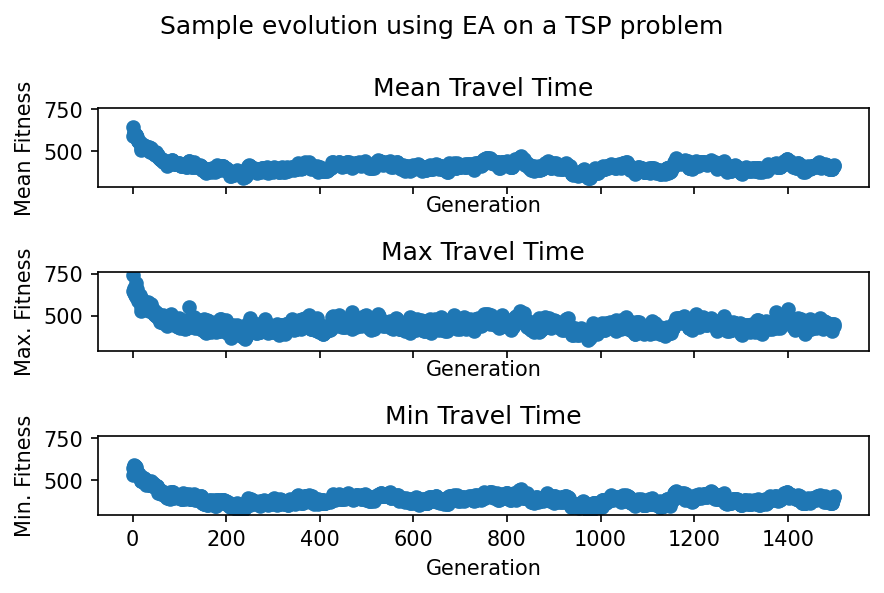

In [45]:
def simple_EA(city_dist:np.ndarray, pop_size:int, max_gen:int):
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, get_travel_time)[:-1])
    # probability for mutation
    p_m = 0.1
    # initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
        
        stats.append(eval_population(new_pop, get_travel_time)[:-1])
        population = new_pop
        gen += 1
    return population, stats
    

# Get Problem Setup
city_dist = get_cities(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
eval_fitness, get_travel_time = get_fitness_func(city_dist)
population, stats = simple_EA(city_dist, pop_size, max_gens)
fig, axs = plt.subplots(3, facecolor='w', sharex=True, sharey=True)
axs[0].scatter(np.arange(max_gens), [stat[0] for stat in stats])
axs[0].title.set_text("Mean Travel Time")
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Fitness')
axs[1].scatter(np.arange(max_gens), [stat[1] for stat in stats])
axs[1].title.set_text("Max Travel Time")
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Max. Fitness')
axs[2].scatter(np.arange(max_gens), [stat[2] for stat in stats])
axs[2].title.set_text("Min Travel Time")
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Min. Fitness')
fig.suptitle("Sample evolution using EA on a TSP problem")
fig.tight_layout()
fig.set_dpi(150)


[33 28 18 24 31 29 38  0 13 12 16 22 17 40 36 37 30 46 45 44 34 48 47 49
 41 26 25 19 39 35 27 43 42  1  6  7 10 21 15 32 11  2  9  8  3  5 23  4
 20 14]


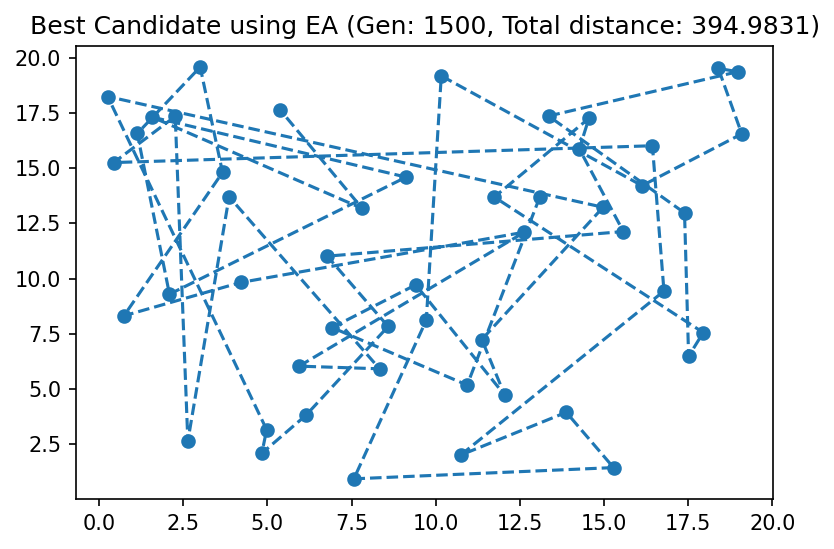

In [46]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, get_travel_time)
best_candidate = population[best_idx]
best_travel_time = get_travel_time(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate using EA (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length
of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt)

In [23]:
def two_opt_swap(phen:List[int], i:int, k:int) -> List[int]:
    new_route = np.zeros(len(phen), dtype=int)
    #1. take route[0] to route[i-1] and add them in order to new_route
    new_route[0:i] = phen[0:i]
    #2. take route[i] to route[k] and add them in reverse order to new_route
    new_route[i:k+1] = np.flip(phen[i:k+1])
    #3. take route[k+1] to end and add them in order to new_route
    new_route[k+1:] = phen[k+1:]
    return new_route

def two_opt_search(phen:List[int], eval_fitness) -> List[int]:
    fitness = eval_fitness(phen)
    found_better_phen = False
    while True:
        for i in range(len(phen)-1):
            for k in range(i+1, len(phen)):
                new_phen = two_opt_swap(phen, i, k)
                new_fitness = eval_fitness(new_phen)
                if new_fitness > fitness:
                    phen = new_phen
                    fitness = new_fitness
                    found_better_phen = True 
                    break
            if found_better_phen:
                found_better_phen = False
                break
        # End local search if no progress has been made
        if not found_better_phen:
            break
    return phen

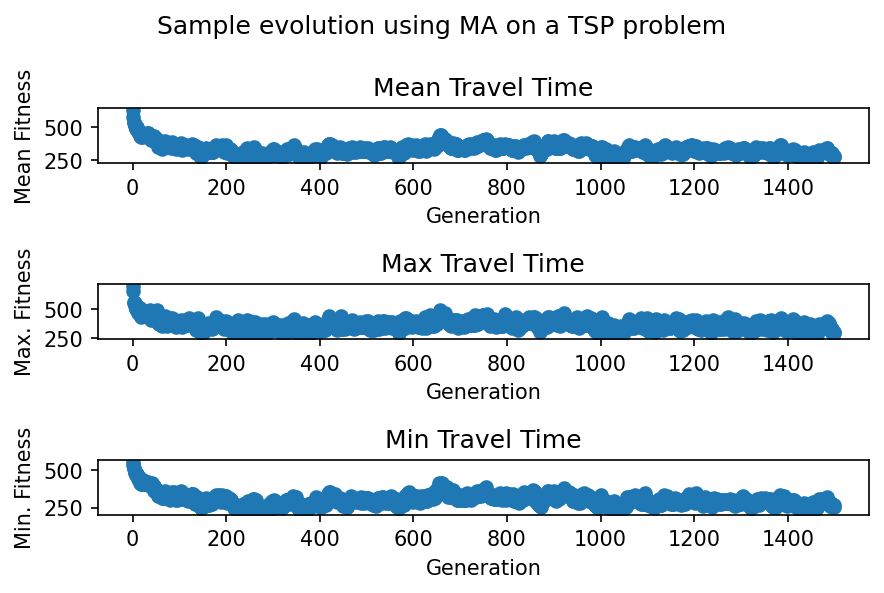

In [47]:
def two_opt_MA(city_dist:np.ndarray, pop_size:int, max_gen:int):
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    for i in range(population.shape[0]):
        population[i] = two_opt_search(population[i], eval_fitness)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, get_travel_time)[:-1])
    # probability for mutation
    p_m = 0.1
    # initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
            new_pop[i] = two_opt_search(new_pop[i], eval_fitness)
            new_pop[i+1] = two_opt_search(new_pop[i], eval_fitness)
        
        stats.append(eval_population(new_pop, get_travel_time)[:-1])
        population = new_pop
        gen += 1
    return population, stats

city_dist = get_cities(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
eval_fitness, get_travel_time = get_fitness_func(city_dist)
population, stats = two_opt_MA(city_dist, pop_size, max_gens)
fig, axs = plt.subplots(3, facecolor='w')
axs[0].scatter(np.arange(max_gens), [stat[0] for stat in stats])
axs[0].title.set_text("Mean Travel Time")
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Fitness')
axs[1].scatter(np.arange(max_gens), [stat[1] for stat in stats])
axs[1].title.set_text("Max Travel Time")
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Max. Fitness')
axs[2].scatter(np.arange(max_gens), [stat[2] for stat in stats])
axs[2].title.set_text("Min Travel Time")
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Min. Fitness')
fig.suptitle("Sample evolution using MA on a TSP problem")
fig.tight_layout()
fig.set_dpi(150)

[21 22 25 31 35 39 45 46 43 40 32 29 28 27 19 12 13 16 15 18 11  5 17 20
 23  2  3 14  6  8 26  0 42 36 34 37 49 48 38 41 10  1  4  9 24 30 33 44
 47  7]
8.3332 5.9161


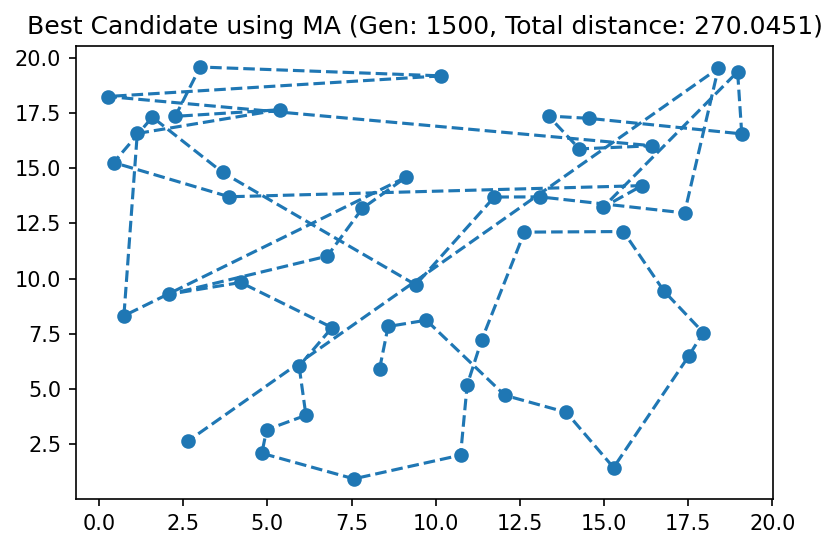

In [48]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, get_travel_time)
best_candidate = population[best_idx]
best_travel_time = get_travel_time(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
print(x_coords[0], y_coords[0])
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate using MA (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

(b) Consider the TSP problem instance given in the file ‘file-tsp’. The file ‘file-
tsp’ contains a 50 ×2 matrix with the coordinates (xi,yi) for city i = 1,...,50.
Also, select a small instance at your choice from the ‘Symmetric Traveling Sales-
man Problem’ benchmark instances available at http://elib.zib.de/pub/
mp-testdata/tsp/tsplib/tsplib.html. Run the MA and EA 10 times on
these two problem instances

In [26]:
# Get data
ulysses_map = get_cities(ulysses_path)
city_map = get_cities(cities_path)
pop_size = 10
max_gens = 1500

a_EA_stats = []
a_MA_stats = []
b_EA_stats = []
b_MA_stats = []
for i in range(10):
    population, stats = simple_EA(city_map, pop_size, max_gens)
    a_EA_stats.append(stats)
    population, stats = two_opt_MA(city_map, pop_size, max_gens)
    a_MA_stats.append(stats)
    population, stats = simple_EA(ulysses_map, pop_size, max_gens)
    b_EA_stats.append(stats)
    population, stats = two_opt_MA(ulysses_map, pop_size, max_gens)
    b_MA_stats.append(stats)

    


(c) For each algorithm (EA and MA), and for each problem instance, provide a
figure containing plots average and best fitness against the elapsed number of
iterations (1500 iterations) for all 10 runs

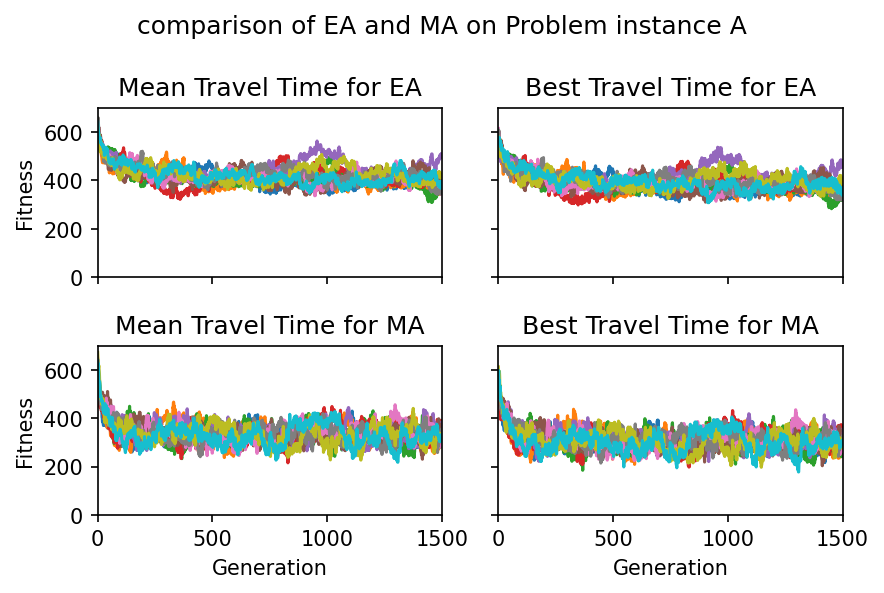

In [50]:
# Plot comparison of EA and MA on Problem instance A
fig, axs = plt.subplots(2, 2, facecolor='w', sharex=True, sharey=True)
plt.xlim(0, 1500)
plt.ylim(0, 700)
for i in range(10):
    axs[0][0].plot(np.arange(max_gens), [stat[0] for stat in a_EA_stats[i]])
    axs[0][1].plot(np.arange(max_gens), [stat[2] for stat in a_EA_stats[i]])
    axs[1][0].plot(np.arange(max_gens), [stat[0] for stat in a_MA_stats[i]])
    axs[1][1].plot(np.arange(max_gens), [stat[2] for stat in a_MA_stats[i]])
axs[0][0].title.set_text("Mean Travel Time for EA")
axs[0][1].title.set_text("Best Travel Time for EA")
axs[1][0].title.set_text("Mean Travel Time for MA")
axs[1][1].title.set_text("Best Travel Time for MA")
plt.setp(axs[-1, :], xlabel='Generation')
plt.setp(axs[:, 0], ylabel='Fitness')
fig.suptitle("comparison of EA and MA on Problem instance A")
fig.tight_layout()
fig.set_dpi(150)

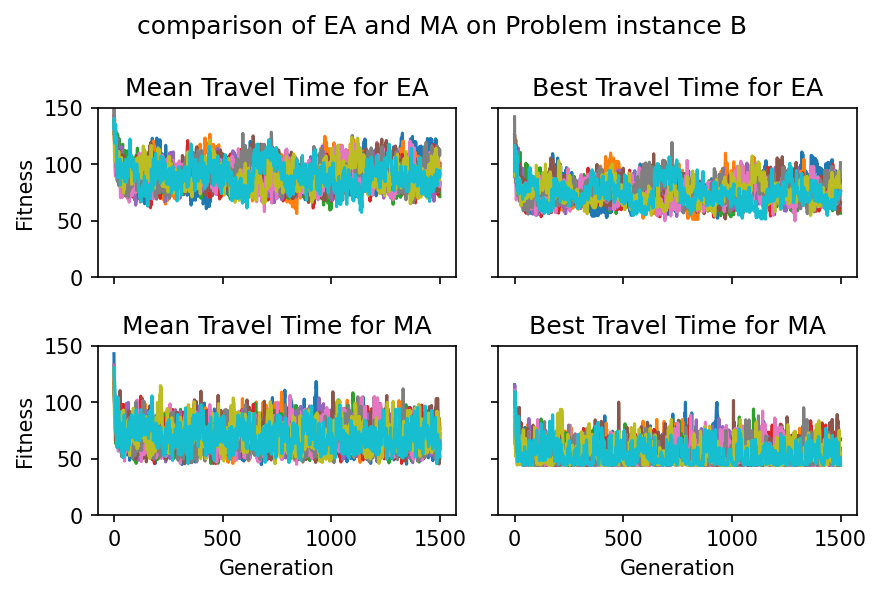

In [51]:
# Plot comparison of EA and MA on Problem instance B
fig, axs = plt.subplots(2,2, facecolor='w', sharex=True, sharey=True)
plt.ylim(0,150)
for i in range(10):
    axs[0][0].plot(np.arange(max_gens), [stat[0] for stat in b_EA_stats[i]])
    axs[0][1].plot(np.arange(max_gens), [stat[2] for stat in b_EA_stats[i]])
    axs[1][0].plot(np.arange(max_gens), [stat[0] for stat in b_MA_stats[i]])
    axs[1][1].plot(np.arange(max_gens), [stat[2] for stat in b_MA_stats[i]])
axs[0][0].title.set_text("Mean Travel Time for EA")
axs[0][1].title.set_text("Best Travel Time for EA")
axs[1][0].title.set_text("Mean Travel Time for MA")
axs[1][1].title.set_text("Best Travel Time for MA")
plt.setp(axs[-1, :], xlabel='Generation')
plt.setp(axs[:, 0], ylabel='Fitness')
fig.suptitle("comparison of EA and MA on Problem instance B")
fig.tight_layout()
fig.set_dpi(150)

(d) Compare the plots of the two algorithms. Which method (EA or MA) works
best?

It is obvious from the plots, that the MA consistently outperforms the EA. 

On problem instance A, we see that the EA finds solutions that are generally in the vicinity of 400. The MA, on the other hand, consistently finds solutions around 300 and even gets close to 200, almost halving the travel times found by EAs.

Problem instance B provides analogous results. While the difference is not as drastic as in A, we see that the MA generally finds better solutions.

(e) Do you consider the above comparison of the MA and EA algorithms (based on
their results over the same number of iterations) fair? Justify your answer. If
your answer is no, then explain what a fair comparison could be.

(f) In general, on the TSP problem, are memetic algorithms more effective than
simple EAs? (To answer this question, please rely on (recent) results from the
literature, and include references to the papers used to answer this question).

Generally speaking, Memetic Algorithms have proven to be more effective on the TSP problem.

One example for this is the NMGA proposed in (Arindam et al, 2019). In the results of their experiments, it is stated that: "[..] The percentage of error [e: To the benchmark solution] is lesser in NMGA than the classical standard GA. Here, 53 standard instances from 7 to 318 cities are studied and most of the cases NMGA produced better results."




References

[Roy, Arindam, Apurba Manna, and Samir Maity. "A novel memetic genetic algorithm for solving traveling salesman problem based on multi-parent crossover technique." Decision Making: Applications in Management and Engineering 2.2 (2019): 100-111.]